In [104]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
import seaborn as sns
import torch
from models import GANFactory

In [105]:
latent_labels = torch.load('fixed_latent_labels.pt', map_location=torch.device('cpu'))
latent_labels = latent_labels.reshape((8, 8))
print(latent_labels)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

labels = []
for i in range(latent_labels.shape[0]):
    labels.append([])
    for j in range(latent_labels.shape[1]):
        labels[i].append(classes[latent_labels[i, j]])
labels = pd.DataFrame(labels)
print(labels)

tensor([[7, 1, 0, 2, 7, 3, 5, 9],
        [8, 7, 7, 3, 1, 1, 5, 5],
        [9, 7, 2, 1, 0, 4, 4, 1],
        [1, 0, 9, 5, 6, 4, 6, 4],
        [1, 3, 2, 5, 3, 1, 3, 4],
        [0, 5, 7, 1, 6, 9, 9, 0],
        [1, 0, 4, 9, 2, 6, 0, 0],
        [7, 3, 4, 9, 3, 0, 8, 9]])
       0      1      2      3      4      5      6      7
0  horse    car  plane   bird  horse    cat    dog  truck
1   ship  horse  horse    cat    car    car    dog    dog
2  truck  horse   bird    car  plane   deer   deer    car
3    car  plane  truck    dog   frog   deer   frog   deer
4    car    cat   bird    dog    cat    car    cat   deer
5  plane    dog  horse    car   frog  truck  truck  plane
6    car  plane   deer  truck   bird   frog  plane  plane
7  horse    cat   deer  truck    cat  plane   ship  truck


In [106]:
# load data
def load_data(dir):
    losses_d = torch.load(os.path.join(dir, 'losses_d.pkl'))
    losses_g = torch.load(os.path.join(dir, 'losses_g.pkl'))
    real_scores = torch.load(os.path.join(dir, 'real_scores.pkl'))
    fake_scores = torch.load(os.path.join(dir, 'fake_scores.pkl'))
    return {
        "losses_d": losses_d, 
        "losses_g": losses_g, 
        "real_scores": real_scores, 
        "fake_scores": fake_scores
    }

In [107]:
# avg for each epoch
def get_avg(data, batch_size=64):
    if batch_size == 32:
        iterations = 1563
    elif batch_size == 64:
        iterations = 782
    elif batch_size == 128:
        iterations = 391
    elif batch_size == 256:
        iterations = 196
    else:
        raise ValueError("Batch size must be 32, 64, or 128")

    avg_data = {}
    for k, v in data.items():
        avg_data[k] = [np.mean(v[i:i+iterations]).item() for i in range(0, len(v), iterations)]
    return avg_data

In [108]:
# load all data for dcgan
dcgan_dirs = []
# load data from basic DC-GAN
dcgan_dirs.append(os.path.join('modelss', 'DC-GAN'))

for i in range(2, 11):
    dcgan_dirs.append(os.path.join('modelss', f'DC-GAN{i}'))

dcgans = [load_data(dir) for dir in dcgan_dirs]
avg_dcgans = [get_avg(dcgan) for dcgan in dcgans]
dcgans.insert(0, 0)
avg_dcgans.insert(0, 0)

# modify for models that have different batch sizes
avg_dcgans[8] = get_avg(dcgans[8], batch_size=128)
avg_dcgans[9] = get_avg(dcgans[9], batch_size=32)

# Experiment 1: DC-GAN

## Compare Different Architectures

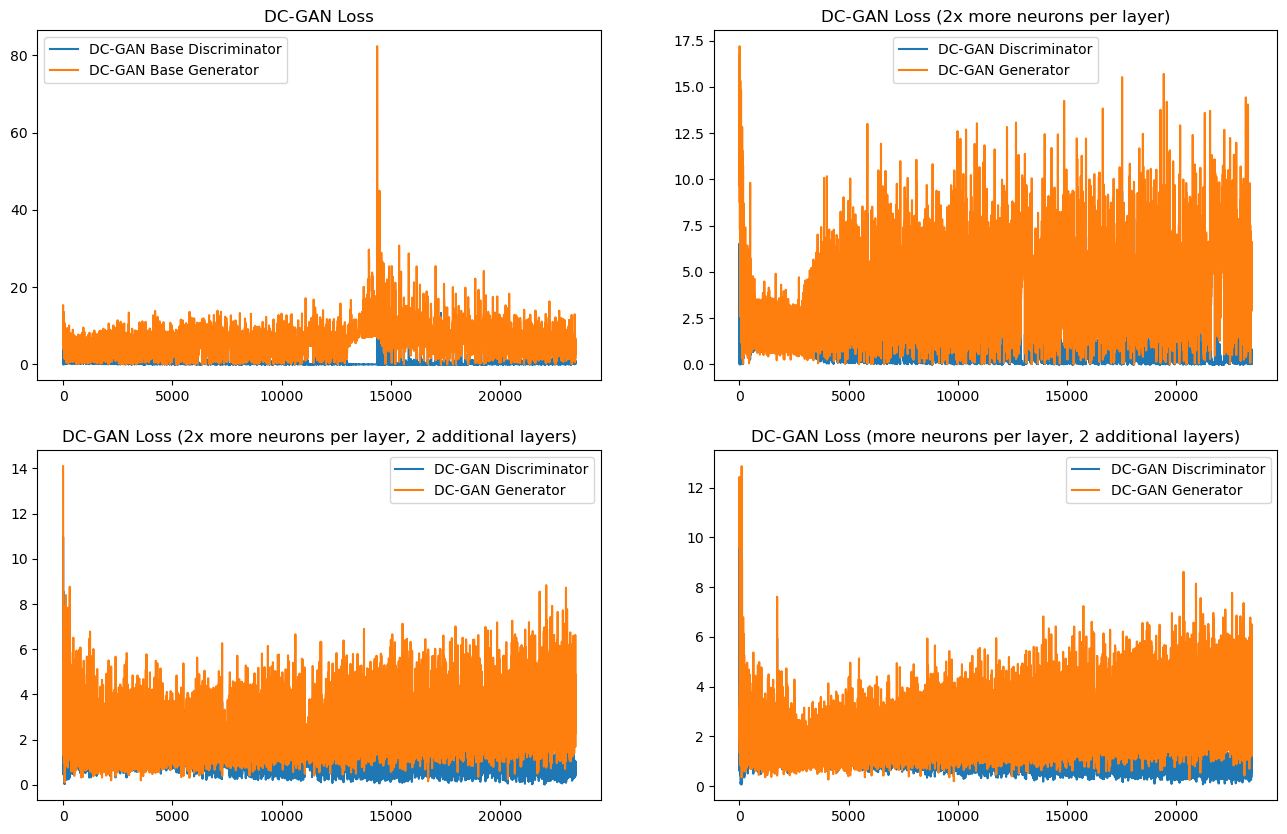

In [109]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# took 28 min
ax[0, 0].set_title('DC-GAN Loss')
ax[0, 0].plot(dcgans[1]['losses_d'], label='DC-GAN Base Discriminator')
ax[0, 0].plot(dcgans[1]['losses_g'], label='DC-GAN Base Generator')
ax[0, 0].legend()

# took 61 min
ax[0, 1].set_title('DC-GAN Loss (2x more neurons per layer)')
ax[0, 1].plot(dcgans[2]['losses_d'], label='DC-GAN Discriminator')
ax[0, 1].plot(dcgans[2]['losses_g'], label='DC-GAN Generator')
ax[0, 1].legend()

# took 111 min
ax[1, 0].set_title('DC-GAN Loss (2x more neurons per layer, 2 additional layers)')
ax[1, 0].plot(dcgans[3]['losses_d'], label='DC-GAN Discriminator')
ax[1, 0].plot(dcgans[3]['losses_g'], label='DC-GAN Generator')
ax[1, 0].legend()

# took 95 min
ax[1, 1].set_title('DC-GAN Loss (more neurons per layer, 2 additional layers)')
ax[1, 1].plot(dcgans[4]['losses_d'], label='DC-GAN Discriminator')
ax[1, 1].plot(dcgans[4]['losses_g'], label='DC-GAN Generator')
ax[1, 1].legend()
plt.show()

<AxesSubplot: title={'center': 'DC-GAN Avg. Generator Loss (Different Architectures)'}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

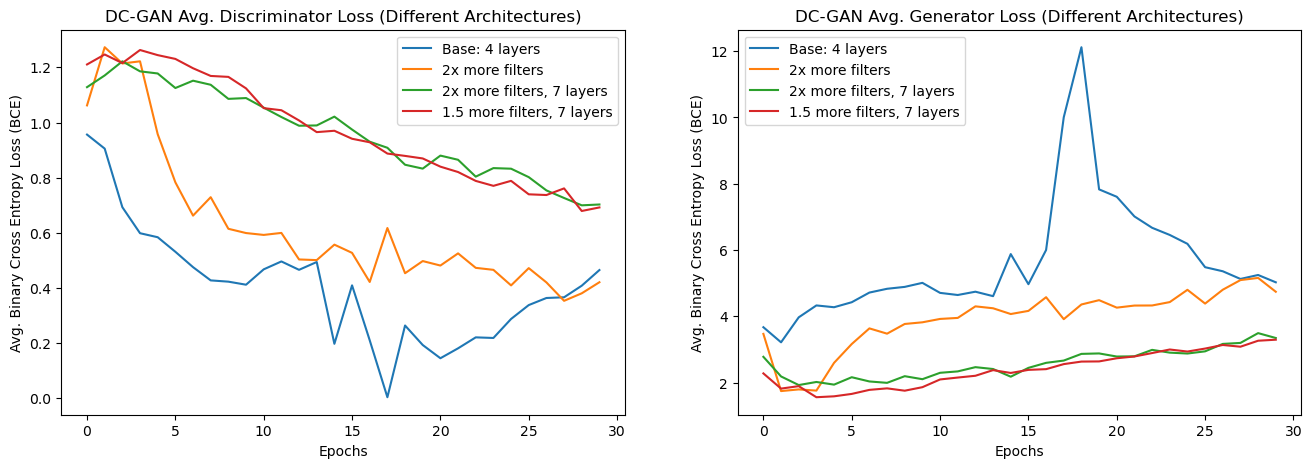

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x = range(len(avg_dcgans[1]['losses_d']))

ax[0].set_title("DC-GAN Avg. Discriminator Loss (Different Architectures)")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dcgans[1]['losses_d'], label='Base: 4 layers', ax=ax[0])
sns.lineplot(x=x, y=avg_dcgans[2]['losses_d'], label='2x more filters', ax=ax[0])
sns.lineplot(x=x, y=avg_dcgans[3]['losses_d'], label='2x more filters, 7 layers', ax=ax[0])
sns.lineplot(x=x, y=avg_dcgans[4]['losses_d'], label='1.5 more filters, 7 layers', ax=ax[0])

ax[1].set_title("DC-GAN Avg. Generator Loss (Different Architectures)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dcgans[1]['losses_g'], label='Base: 4 layers', ax=ax[1])
sns.lineplot(x=x, y=avg_dcgans[2]['losses_g'], label='2x more filters', ax=ax[1])
sns.lineplot(x=x, y=avg_dcgans[3]['losses_g'], label='2x more filters, 7 layers', ax=ax[1])
sns.lineplot(x=x, y=avg_dcgans[4]['losses_g'], label='1.5 more filters, 7 layers', ax=ax[1])

# ax[1, 0].set_title("DC-GAN Real Scores")
# sns.lineplot(x=x, y=avg_dcgans[1]['real_scores'], label='Base: 4 layers', ax=ax[1, 0])
# sns.lineplot(x=x, y=avg_dcgans[2]['real_scores'], label='2x more filters', ax=ax[1, 0])
# sns.lineplot(x=x, y=avg_dcgans[3]['real_scores'], label='2x more filters, 6 layers', ax=ax[1, 0])
# sns.lineplot(x=x, y=avg_dcgans[4]['real_scores'], label='1.5 more filters, 6 layers', ax=ax[1, 0])

# ax[1, 1].set_title("DC-GAN Generated Scores")
# sns.lineplot(x=x, y=avg_dcgans[1]['fake_scores'], label='Base: 4 layers', ax=ax[1, 1])
# sns.lineplot(x=x, y=avg_dcgans[2]['fake_scores'], label='2x more filters', ax=ax[1, 1])
# sns.lineplot(x=x, y=avg_dcgans[3]['fake_scores'], label='2x more filters, 6 layers', ax=ax[1, 1])
# sns.lineplot(x=x, y=avg_dcgans[4]['fake_scores'], label='1.5 more filters, 6 layers', ax=ax[1, 1])

## Compare Different Activation Functions

<AxesSubplot: title={'center': 'Optimal DC-GAN Avg. Generator Loss'}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

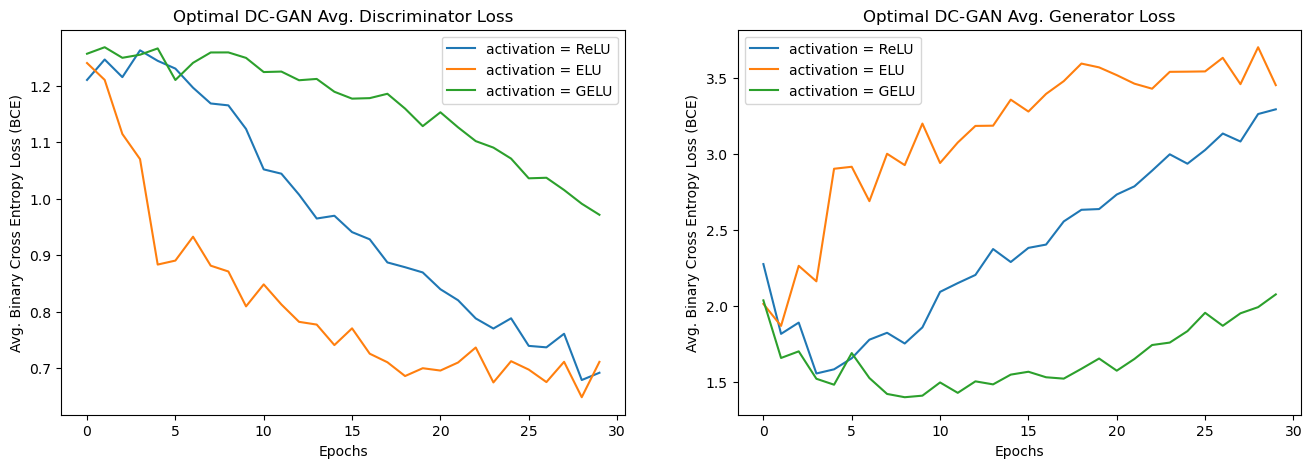

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x = range(len(avg_dcgans[1]['losses_d']))

ax[0].set_title("Optimal DC-GAN Avg. Discriminator Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dcgans[4]['losses_d'], label='activation = ReLU', ax=ax[0])
sns.lineplot(x=x, y=avg_dcgans[7]['losses_d'], label='activation = ELU', ax=ax[0])
sns.lineplot(x=x, y=avg_dcgans[10]['losses_d'], label='activation = GELU', ax=ax[0])

ax[1].set_title("Optimal DC-GAN Avg. Generator Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dcgans[4]['losses_g'], label='activation = ReLU', ax=ax[1])
sns.lineplot(x=x, y=avg_dcgans[7]['losses_g'], label='activation = ELU', ax=ax[1])
sns.lineplot(x=x, y=avg_dcgans[10]['losses_g'], label='activation = GELU', ax=ax[1])

Since I found that the best performing generator model was the one with two extra convolutional layers (one upsample, one downsample), I used that model to test the different activation functions on that. I found that ReLU (the original) performed the best with the least amount of average loss per epoch, compared to ELU and GELU (Gaussian).

## Compare Different Batch Sizes

<AxesSubplot: title={'center': 'DC-GAN Avg. Generator Loss (Different Batch Sizes)'}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

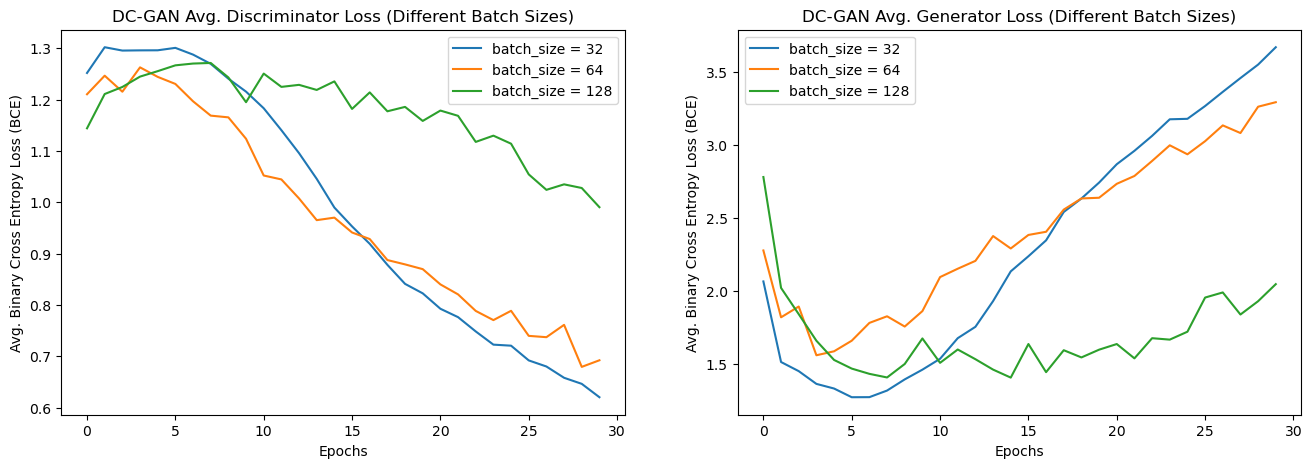

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x = range(len(avg_dcgans[1]['losses_d']))

ax[0].set_title("DC-GAN Avg. Discriminator Loss (Different Batch Sizes)")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dcgans[9]['losses_d'], label='batch_size = 32', ax=ax[0])
sns.lineplot(x=x, y=avg_dcgans[4]['losses_d'], label='batch_size = 64', ax=ax[0])
sns.lineplot(x=x, y=avg_dcgans[8]['losses_d'], label='batch_size = 128', ax=ax[0])

ax[1].set_title("DC-GAN Avg. Generator Loss (Different Batch Sizes)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dcgans[9]['losses_g'], label='batch_size = 32', ax=ax[1])
sns.lineplot(x=x, y=avg_dcgans[4]['losses_g'], label='batch_size = 64', ax=ax[1])
sns.lineplot(x=x, y=avg_dcgans[8]['losses_g'], label='batch_size = 128', ax=ax[1])

## Best Model of DC-GAN:

Best model was `dcgan8`

- more neurons at each layer
- use ReLU activation; although GELU had better loss for both discriminator/generator, generated images were worse
- add one upsampling and one downsampling convolutional layer
- `batch_size = 128`

# Experiment 2: DCGAN with Conditional Input (DC-cGAN)

In [113]:
# load data from conditional DC-GAN
dccgan_dirs = []
dccgan_dirs.append(os.path.join('modelss', 'DC-cGAN'))

for i in range(2, 12):
    dccgan_dirs.append(os.path.join('modelss', f'DC-cGAN{i}'))

dccgans = [load_data(dir) for dir in dccgan_dirs]
avg_dccgans = [get_avg(dccgan, batch_size=128) for dccgan in dccgans]
dccgans.insert(0, 0)
avg_dccgans.insert(0, 0)

## Experiment with Architecture

We will use the same architecture as the most optimal DCGAN model, but with the conditional input. Then change as necessary, as well as compare accuracy with previous DCGAN models for reference.

<AxesSubplot: title={'center': 'DC-GAN Avg. Generator Loss (Different Architectures)'}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

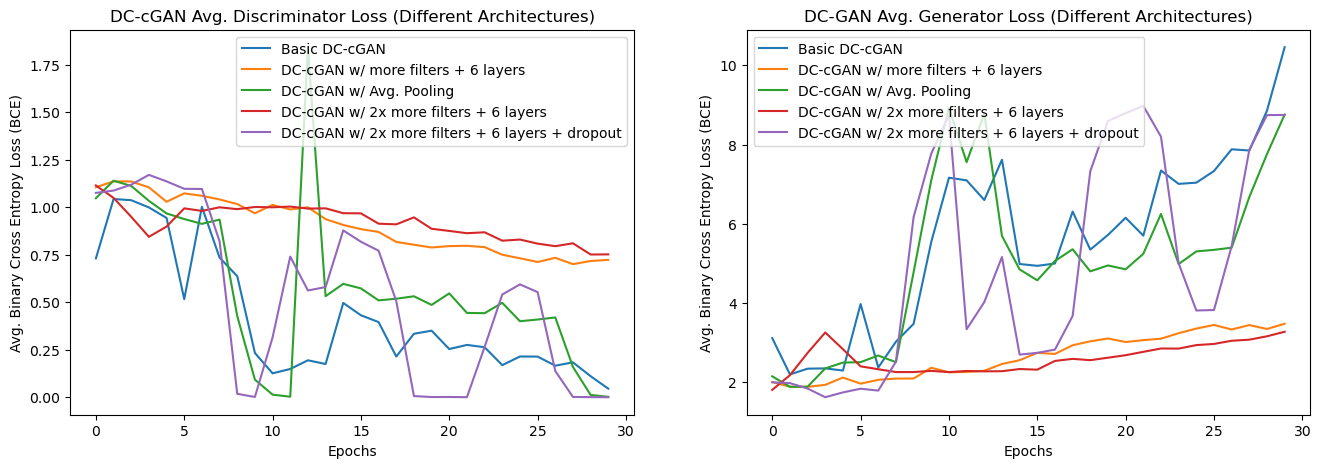

In [114]:
# Experiment with architecture
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x1 = range(len(avg_dcgans[1]['losses_d']))
x = range(len(avg_dccgans[1]['losses_d']))

ax[0].set_title("DC-cGAN Avg. Discriminator Loss (Different Architectures)")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dccgans[1]['losses_d'], label='Basic DC-cGAN', ax=ax[0])
sns.lineplot(x=x, y=avg_dccgans[2]['losses_d'], label='DC-cGAN w/ more filters + 6 layers', ax=ax[0])
sns.lineplot(x=x, y=avg_dccgans[4]['losses_d'], label='DC-cGAN w/ Avg. Pooling', ax=ax[0])
sns.lineplot(x=x, y=avg_dccgans[8]['losses_d'], label='DC-cGAN w/ 2x more filters + 6 layers', ax=ax[0])
sns.lineplot(x=x, y=avg_dccgans[9]['losses_d'], label='DC-cGAN w/ 2x more filters + 6 layers + dropout', ax=ax[0])

ax[1].set_title("DC-GAN Avg. Generator Loss (Different Architectures)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dccgans[1]['losses_g'], label='Basic DC-cGAN', ax=ax[1])
sns.lineplot(x=x, y=avg_dccgans[2]['losses_g'], label='DC-cGAN w/ more filters + 6 layers', ax=ax[1])
sns.lineplot(x=x, y=avg_dccgans[4]['losses_g'], label='DC-cGAN w/ Avg. Pooling', ax=ax[1])
sns.lineplot(x=x, y=avg_dccgans[8]['losses_g'], label='DC-cGAN w/ 2x more filters + 6 layers', ax=ax[1])
sns.lineplot(x=x, y=avg_dccgans[9]['losses_g'], label='DC-cGAN w/ 2x more filters + 6 layers + dropout', ax=ax[1])

## Experiment with Activation Functions

<AxesSubplot: title={'center': 'DC-cGAN Avg. Generator Loss (Different Activations)'}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

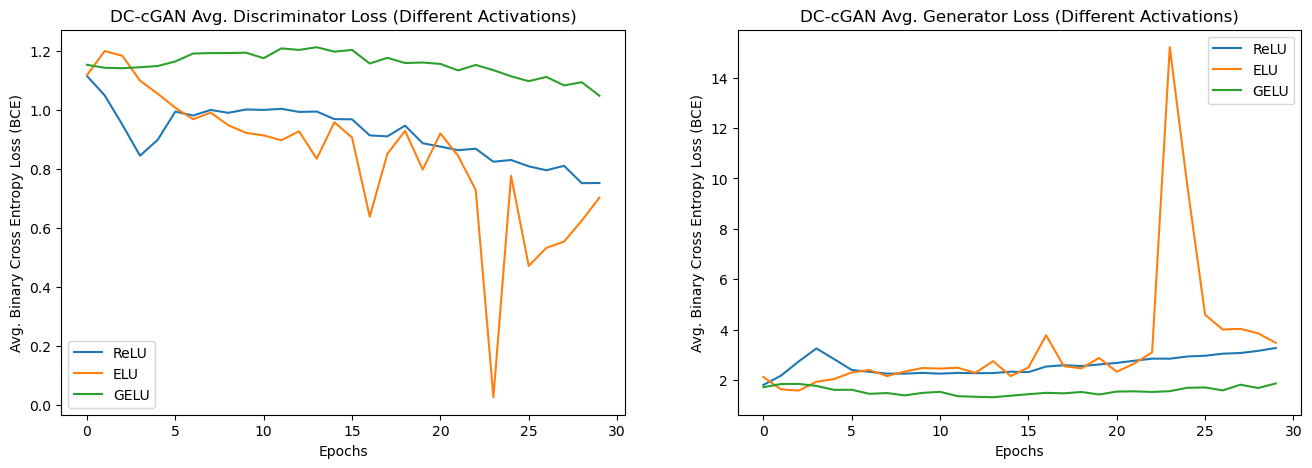

In [115]:
# Experiment with activation functions
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x = range(len(avg_dccgans[1]['losses_d']))

ax[0].set_title("DC-cGAN Avg. Discriminator Loss (Different Activations)")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dccgans[8]['losses_d'], label='ReLU', ax=ax[0])
sns.lineplot(x=x, y=avg_dccgans[3]['losses_d'], label='ELU', ax=ax[0])
sns.lineplot(x=x, y=avg_dccgans[5]['losses_d'], label='GELU', ax=ax[0])

ax[1].set_title("DC-cGAN Avg. Generator Loss (Different Activations)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_dccgans[8]['losses_g'], label='ReLU', ax=ax[1])
sns.lineplot(x=x, y=avg_dccgans[3]['losses_g'], label='ELU', ax=ax[1])
sns.lineplot(x=x, y=avg_dccgans[5]['losses_g'], label='GELU', ax=ax[1])

## Experiment with Hyperparameters (`epoch`)

<AxesSubplot: title={'center': "'Optimal' DC-cGAN Generator Loss"}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

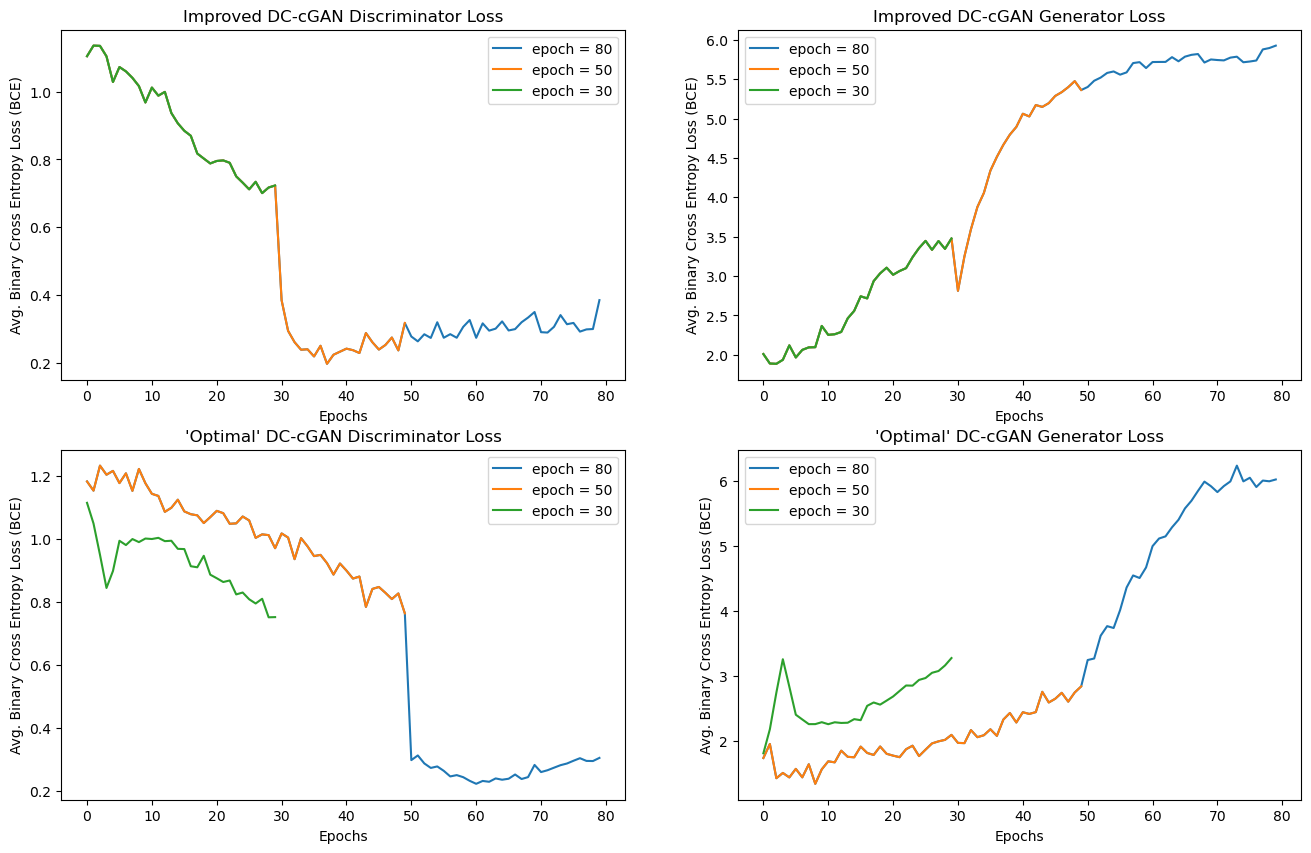

In [116]:
# Experiment with activation functions
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

x = range(len(avg_dccgans[2]['losses_d']))
x1 = range(len(avg_dccgans[6]['losses_d']))
x2 = range(len(avg_dccgans[7]['losses_d']))

ax[0, 0].set_title("Improved DC-cGAN Discriminator Loss")
ax[0, 0].set_xlabel("Epochs")
ax[0, 0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x2, y=avg_dccgans[7]['losses_d'], label='epoch = 80', ax=ax[0, 0])
sns.lineplot(x=x1, y=avg_dccgans[6]['losses_d'], label='epoch = 50', ax=ax[0, 0])
sns.lineplot(x=x, y=avg_dccgans[2]['losses_d'], label='epoch = 30', ax=ax[0, 0])

ax[0, 1].set_title("Improved DC-cGAN Generator Loss")
ax[0, 1].set_xlabel("Epochs")
ax[0, 1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x2, y=avg_dccgans[7]['losses_g'], label='epoch = 80', ax=ax[0, 1])
sns.lineplot(x=x1, y=avg_dccgans[6]['losses_g'], label='epoch = 50', ax=ax[0, 1])
sns.lineplot(x=x, y=avg_dccgans[2]['losses_g'], label='epoch = 30', ax=ax[0, 1])

x = range(len(avg_dccgans[8]['losses_d']))
x1 = range(len(avg_dccgans[10]['losses_d']))
x2 = range(len(avg_dccgans[11]['losses_d']))

ax[1, 0].set_title("'Optimal' DC-cGAN Discriminator Loss")
ax[1, 0].set_xlabel("Epochs")
ax[1, 0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x2, y=avg_dccgans[11]['losses_d'], label='epoch = 80', ax=ax[1, 0])
sns.lineplot(x=x1, y=avg_dccgans[10]['losses_d'], label='epoch = 50', ax=ax[1, 0])
sns.lineplot(x=x, y=avg_dccgans[8]['losses_d'], label='epoch = 30', ax=ax[1, 0])

ax[1, 1].set_title("'Optimal' DC-cGAN Generator Loss")
ax[1, 1].set_xlabel("Epochs")
ax[1, 1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x2, y=avg_dccgans[11]['losses_g'], label='epoch = 80', ax=ax[1, 1])
sns.lineplot(x=x1, y=avg_dccgans[10]['losses_g'], label='epoch = 50', ax=ax[1, 1])
sns.lineplot(x=x, y=avg_dccgans[8]['losses_g'], label='epoch = 30', ax=ax[1, 1])

As already seen here, the optimal DC-cGAN works very well.

# Experiment 3: RC-cGAN (Add ResNet with DC-cGAN)

**Might merge with DC-cGAN experiments, because poor results with adding ResNets.** Add to changes to architecture

In [151]:
# load data from RC-cGAN
rccgan_dirs = []

for i in range(1, 5):
    rccgan_dirs.append(os.path.join('modelss', f'RC-cGAN{i}'))

rccgans = [load_data(dir) for dir in rccgan_dirs]
avg_rccgans = [get_avg(rccgan, batch_size=128) for rccgan in rccgans]
rccgans.insert(0, 0)
avg_rccgans.insert(0, 0)

## Experiment with Architecture

<AxesSubplot: title={'center': 'RC-cGAN Generator Avg. Loss'}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

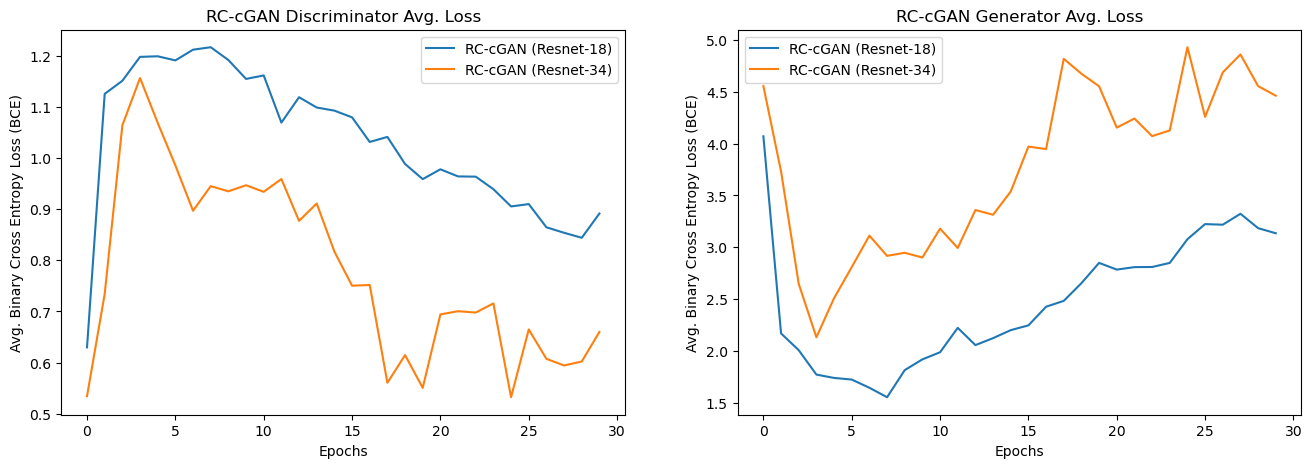

In [152]:
# Experiment with architecture
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x = range(len(avg_rccgans[1]['losses_d']))

ax[0].set_title("RC-cGAN Discriminator Avg. Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_rccgans[1]['losses_d'], label='RC-cGAN (Resnet-18)', ax=ax[0])
sns.lineplot(x=x, y=avg_rccgans[2]['losses_d'], label='RC-cGAN (Resnet-34)', ax=ax[0])

ax[1].set_title("RC-cGAN Generator Avg. Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x, y=avg_rccgans[1]['losses_g'], label='RC-cGAN (Resnet-18)', ax=ax[1])
sns.lineplot(x=x, y=avg_rccgans[2]['losses_g'], label='RC-cGAN (Resnet-34)', ax=ax[1])

<AxesSubplot: title={'center': 'Generator Loss (compare with RC-cGANs)'}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

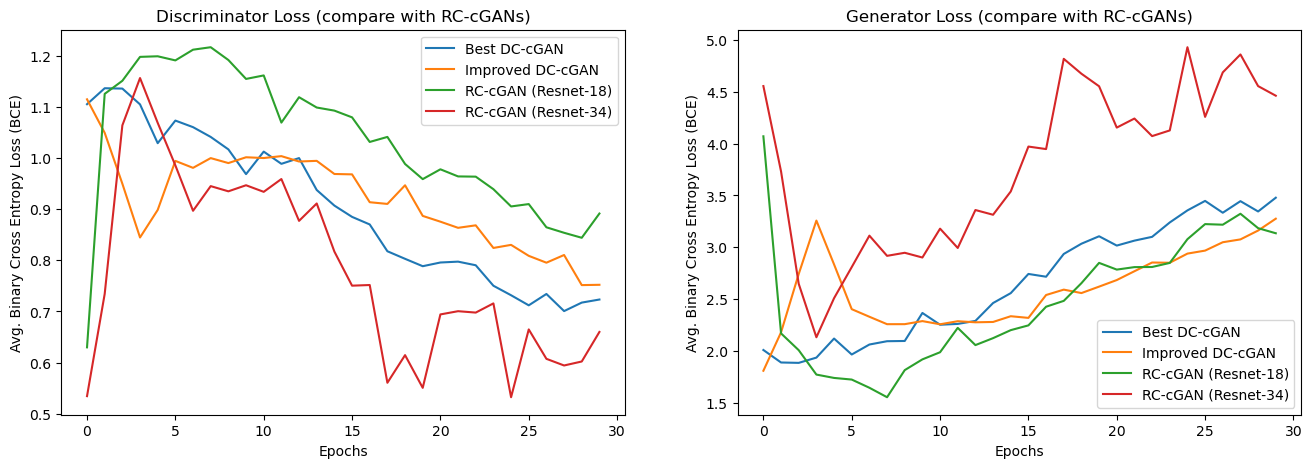

In [153]:
# Experiment with architecture
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x1 = range(len(avg_dccgans[1]['losses_d']))
x = range(len(avg_rccgans[1]['losses_d']))

ax[0].set_title("Discriminator Loss (compare with RC-cGANs)")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x1, y=avg_dccgans[2]['losses_d'], label='Best DC-cGAN', ax=ax[0])
sns.lineplot(x=x1, y=avg_dccgans[8]['losses_d'], label='Improved DC-cGAN', ax=ax[0])
sns.lineplot(x=x, y=avg_rccgans[1]['losses_d'], label='RC-cGAN (Resnet-18)', ax=ax[0])
sns.lineplot(x=x, y=avg_rccgans[2]['losses_d'], label='RC-cGAN (Resnet-34)', ax=ax[0])

ax[1].set_title("Generator Loss (compare with RC-cGANs)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x1, y=avg_dccgans[2]['losses_g'], label='Best DC-cGAN', ax=ax[1])
sns.lineplot(x=x1, y=avg_dccgans[8]['losses_g'], label='Improved DC-cGAN', ax=ax[1])
sns.lineplot(x=x, y=avg_rccgans[1]['losses_g'], label='RC-cGAN (Resnet-18)', ax=ax[1])
sns.lineplot(x=x, y=avg_rccgans[2]['losses_g'], label='RC-cGAN (Resnet-34)', ax=ax[1])

<AxesSubplot: title={'center': 'DC-GAN Generator Loss over 50 epochs'}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

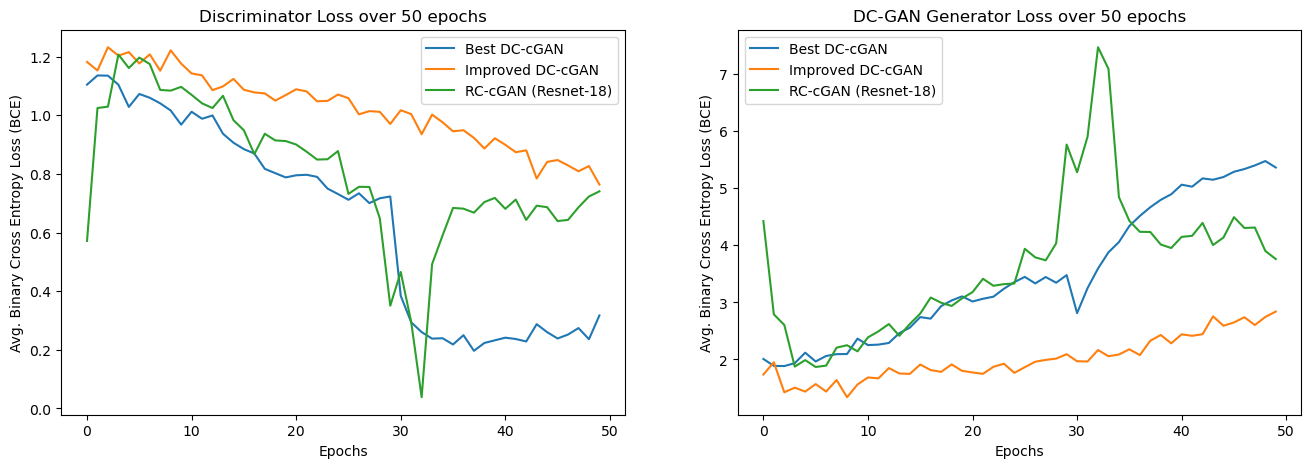

In [154]:
# longe
# Experiment with architecture
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x2 = range(len(avg_dccgans[6]['losses_d']))
x1 = range(len(avg_dccgans[10]['losses_d']))
x = range(len(avg_rccgans[3]['losses_d']))

ax[0].set_title("Discriminator Loss over 50 epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x2, y=avg_dccgans[6]['losses_d'], label='Best DC-cGAN', ax=ax[0])
sns.lineplot(x=x1, y=avg_dccgans[10]['losses_d'], label='Improved DC-cGAN', ax=ax[0])
sns.lineplot(x=x, y=avg_rccgans[3]['losses_d'], label='RC-cGAN (Resnet-18)', ax=ax[0])

ax[1].set_title("DC-GAN Generator Loss over 50 epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x2, y=avg_dccgans[6]['losses_g'], label='Best DC-cGAN', ax=ax[1])
sns.lineplot(x=x1, y=avg_dccgans[10]['losses_g'], label='Improved DC-cGAN', ax=ax[1])
sns.lineplot(x=x, y=avg_rccgans[3]['losses_g'], label='RC-cGAN (Resnet-18)', ax=ax[1])

# Overall Comparisons: DC-GAN vs. DC-cGAN vs. RC-cGAN

<AxesSubplot: title={'center': 'Generator Loss'}, xlabel='Epochs', ylabel='Avg. Binary Cross Entropy Loss (BCE)'>

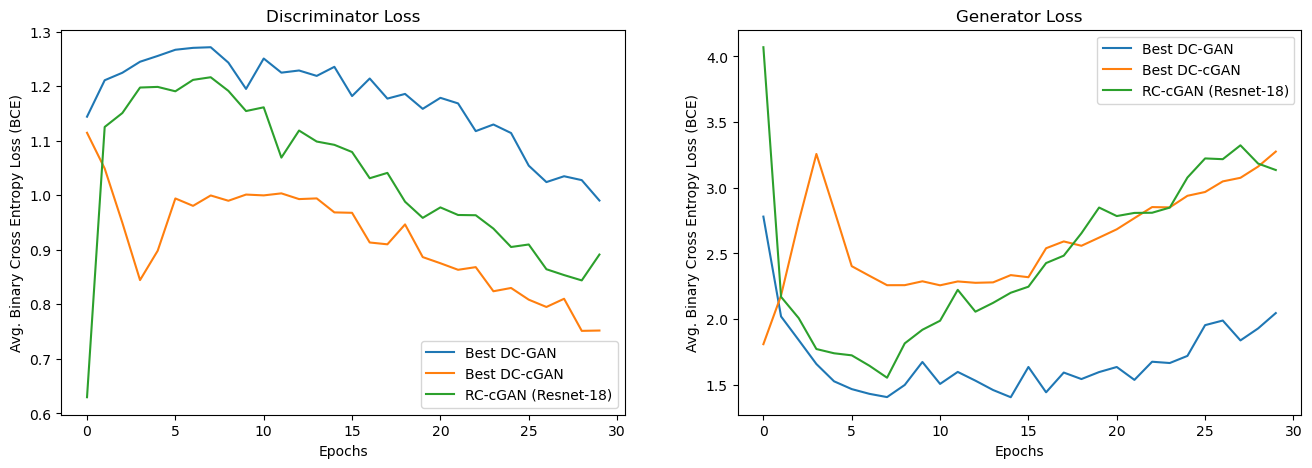

In [155]:
# Experiment with architecture
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x2 = range(len(avg_dcgans[8]['losses_d']))
x1 = range(len(avg_dccgans[2]['losses_d']))
x = range(len(avg_rccgans[1]['losses_d']))

ax[0].set_title("Discriminator Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x2, y=avg_dcgans[8]['losses_d'], label='Best DC-GAN', ax=ax[0])
sns.lineplot(x=x1, y=avg_dccgans[8]['losses_d'], label='Best DC-cGAN', ax=ax[0])
sns.lineplot(x=x, y=avg_rccgans[1]['losses_d'], label='RC-cGAN (Resnet-18)', ax=ax[0])

ax[1].set_title("Generator Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Binary Cross Entropy Loss (BCE)")
sns.lineplot(x=x2, y=avg_dcgans[8]['losses_g'], label='Best DC-GAN', ax=ax[1])
sns.lineplot(x=x1, y=avg_dccgans[8]['losses_g'], label='Best DC-cGAN', ax=ax[1])
sns.lineplot(x=x, y=avg_rccgans[1]['losses_g'], label='RC-cGAN (Resnet-18)', ax=ax[1])

<AxesSubplot: title={'center': 'Average Generated Image Scores'}, xlabel='Epochs', ylabel='Avg. Scores [0-1]'>

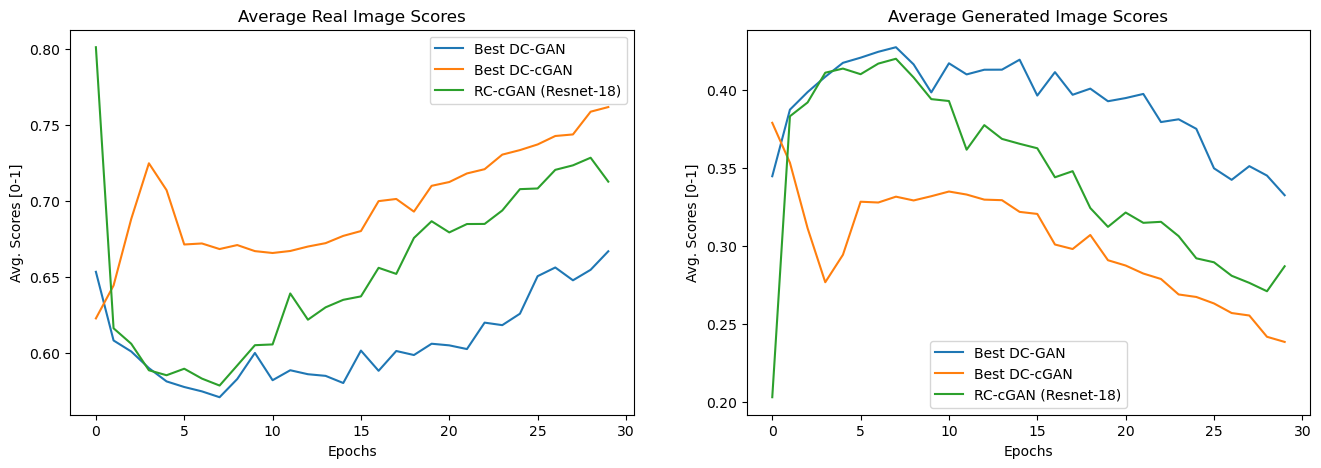

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x2 = range(len(avg_dcgans[8]['losses_d']))
x1 = range(len(avg_dccgans[2]['losses_d']))
x = range(len(avg_rccgans[1]['losses_d']))

ax[0].set_title("Average Real Image Scores")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Avg. Scores [0-1]")
sns.lineplot(x=x2, y=avg_dcgans[8]['real_scores'], label='Best DC-GAN', ax=ax[0])
sns.lineplot(x=x1, y=avg_dccgans[8]['real_scores'], label='Best DC-cGAN', ax=ax[0])
sns.lineplot(x=x, y=avg_rccgans[1]['real_scores'], label='RC-cGAN (Resnet-18)', ax=ax[0])

ax[1].set_title("Average Generated Image Scores")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Avg. Scores [0-1]")
sns.lineplot(x=x2, y=avg_dcgans[8]['fake_scores'], label='Best DC-GAN', ax=ax[1])
sns.lineplot(x=x1, y=avg_dccgans[8]['fake_scores'], label='Best DC-cGAN', ax=ax[1])
sns.lineplot(x=x, y=avg_rccgans[1]['fake_scores'], label='RC-cGAN (Resnet-18)', ax=ax[1])

In [157]:
# plot images
dcgan_img_dir = os.path.join('Report', 'images', 'dcgan-experiments')
dccgan_img_dir = os.path.join('Report', 'images', 'dccgan-experiments')
rccgan_img_dir = os.path.join('Report', 'images', 'rccgan-experiments')

# Get images
optimal_dcgan = mpimg.imread(os.path.join(dcgan_img_dir, 'generated-dcgan8.png'))   # 30 epochs
optimal_dcgan2 = mpimg.imread(os.path.join(dcgan_img_dir, 'generated-dcgan11.png'))   # 30 epochs
optimal_dcgan3 = mpimg.imread(os.path.join(dcgan_img_dir, 'generated-dcgan12.png'))   # 30 epochs

optimal_dccgan = mpimg.imread(os.path.join(dccgan_img_dir, 'dccgan2.png'))          # 30 epochs
optimal_dccgan2 = mpimg.imread(os.path.join(dccgan_img_dir, 'dccgan6.png'))         # 50 epochs
optimal_dccgan3 = mpimg.imread(os.path.join(dccgan_img_dir, 'dccgan7.png'))         # 80 epochs

best_dccgan = mpimg.imread(os.path.join(dccgan_img_dir, 'dccgan8.png'))             # 30 epochs
best_dccgan2 = mpimg.imread(os.path.join(dccgan_img_dir, 'dccgan10.png'))           # 50 epochs
best_dccgan3 = mpimg.imread(os.path.join(dccgan_img_dir, 'dccgan11.png'))           # 80 epochs

best_rccgan = mpimg.imread(os.path.join(rccgan_img_dir, 'rccgan1.png'))          # 30 epochs
best_rccgan2 = mpimg.imread(os.path.join(rccgan_img_dir, 'rccgan3.png'))         # 50 epochs

ok_rccgan = mpimg.imread(os.path.join(rccgan_img_dir, 'rccgan2.png'))          # 30 epochs

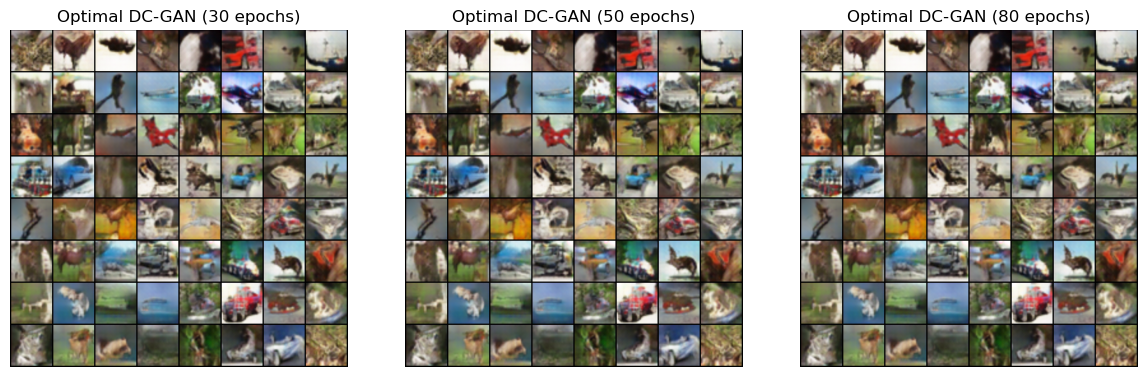

In [158]:
# show 30 - 50 - 80 epoches for optimal dcgan 

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout()

ax[0].set_title("Optimal DC-GAN (30 epochs)")
ax[0].imshow(optimal_dcgan)
ax[0].axis('off')

ax[1].set_title("Optimal DC-GAN (50 epochs)")
ax[1].imshow(optimal_dcgan)
ax[1].axis('off')

ax[2].set_title("Optimal DC-GAN (80 epochs)")
ax[2].imshow(optimal_dcgan)
ax[2].axis('off')

plt.show()

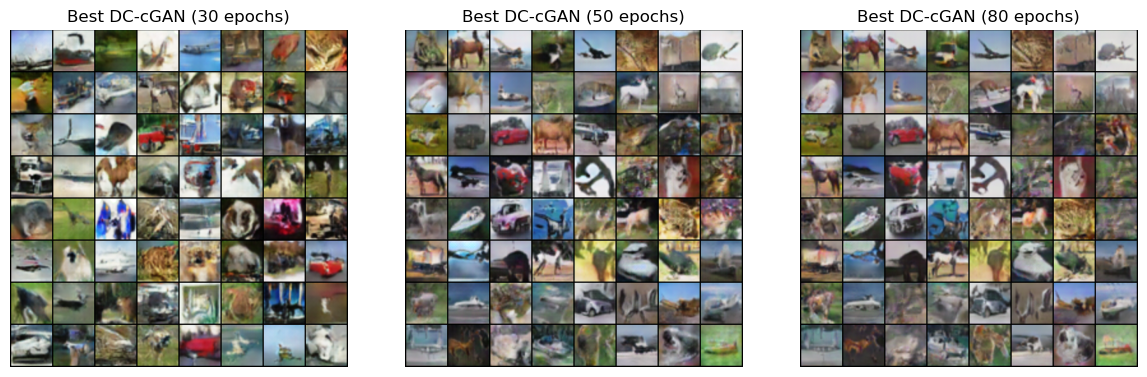

In [159]:
# show 30 - 50 - 80 epochs for optimal dccgan

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout()

# ax[0, 0].set_title("Optimal DC-cGAN (30 epochs)")
# ax[0, 0].imshow(optimal_dccgan)
# ax[0, 0].axis('off')

# ax[0, 1].set_title("Optimal DC-cGAN (50 epochs)")
# ax[0, 1].imshow(optimal_dccgan2)
# ax[0, 1].axis('off')

# ax[0, 2].set_title("Optimal DC-cGAN (80 epochs)")
# ax[0, 2].imshow(optimal_dccgan3)
# ax[0, 2].axis('off')

ax[0].set_title("Best DC-cGAN (30 epochs)")
ax[0].imshow(best_dccgan)
ax[0].axis('off')

ax[1].set_title("Best DC-cGAN (50 epochs)")
ax[1].imshow(best_dccgan2)
ax[1].axis('off')

ax[2].set_title("Best DC-cGAN (80 epochs)")
ax[2].imshow(best_dccgan3)
ax[2].axis('off')

plt.show()

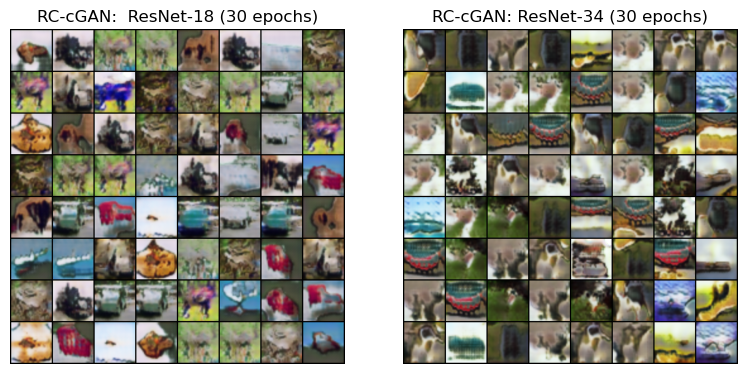

In [160]:
# show 30 - 50 epochs for optimal rccgan

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout()

ax[0].set_title("RC-cGAN:  ResNet-18 (30 epochs)")
ax[0].imshow(best_rccgan)
ax[0].axis('off')

ax[1].set_title("RC-cGAN: ResNet-34 (30 epochs)")
ax[1].imshow(ok_rccgan)
ax[1].axis('off')

plt.show()

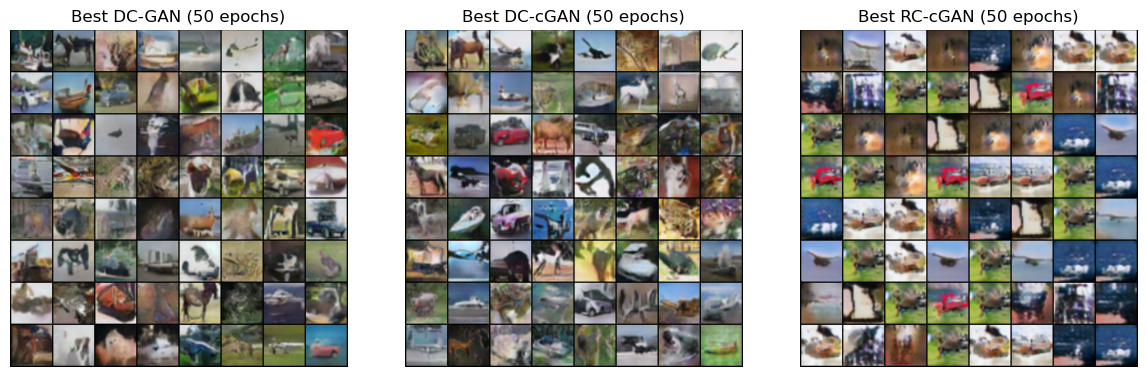

In [168]:
# show images
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout()

ax[0].set_title("Best DC-GAN (50 epochs)")
ax[0].imshow(optimal_dcgan2)
ax[0].axis('off')

ax[1].set_title("Best DC-cGAN (50 epochs)")
ax[1].imshow(best_dccgan2)
ax[1].axis('off')

ax[2].set_title("Best RC-cGAN (50 epochs)")
ax[2].imshow(best_rccgan2)
ax[2].axis('off')
plt.show()

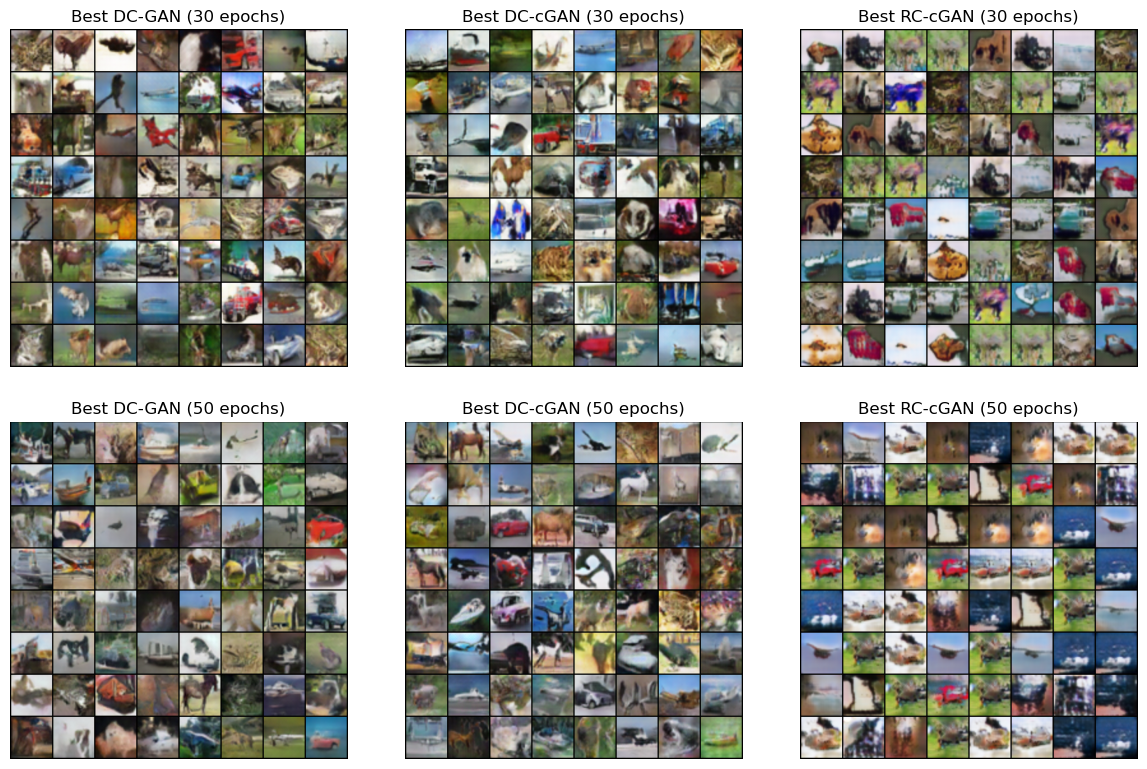

In [167]:
# show images
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout()

ax[0, 0].set_title("Best DC-GAN (30 epochs)")
ax[0, 0].imshow(optimal_dcgan)
ax[0, 0].axis('off')

ax[0, 1].set_title("Best DC-cGAN (30 epochs)")
ax[0, 1].imshow(best_dccgan)
ax[0, 1].axis('off')

ax[0, 2].set_title("Best RC-cGAN (30 epochs)")
ax[0, 2].imshow(best_rccgan)
ax[0, 2].axis('off')

ax[1, 0].set_title("Best DC-GAN (50 epochs)")
ax[1, 0].imshow(optimal_dcgan2)
ax[1, 0].axis('off')

ax[1, 1].set_title("Best DC-cGAN (50 epochs)")
ax[1, 1].imshow(best_dccgan2)
ax[1, 1].axis('off')

ax[1, 2].set_title("Best RC-cGAN (50 epochs)")
ax[1, 2].imshow(best_rccgan2)
ax[1, 2].axis('off')
plt.show()

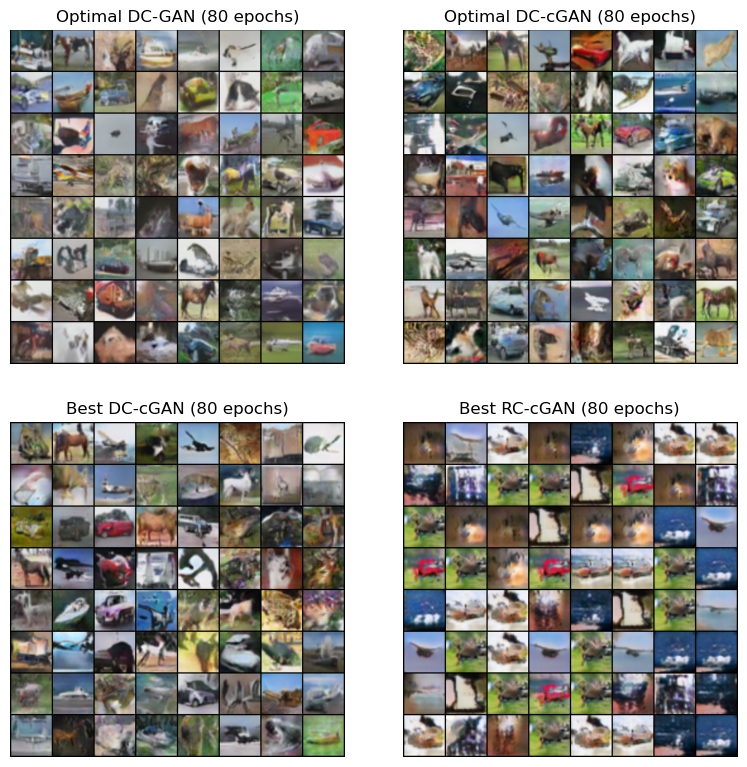

In [163]:
# show images
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout()

ax[0, 0].set_title("Optimal DC-GAN (80 epochs)")
ax[0, 0].imshow(optimal_dcgan3)
ax[0, 0].axis('off')

ax[0, 1].set_title("Optimal DC-cGAN (80 epochs)")
ax[0, 1].imshow(optimal_dccgan3)
ax[0, 1].axis('off')

ax[1, 0].set_title("Best DC-cGAN (80 epochs)")
ax[1, 0].imshow(best_dccgan2)
ax[1, 0].axis('off')

ax[1, 1].set_title("Best RC-cGAN (80 epochs)")
ax[1, 1].imshow(best_rccgan2)
ax[1, 1].axis('off')
plt.show()